In [1]:
# Importing relevant libraries and loading my dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier


df = pd.read_csv("diabetes.csv")

In [2]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


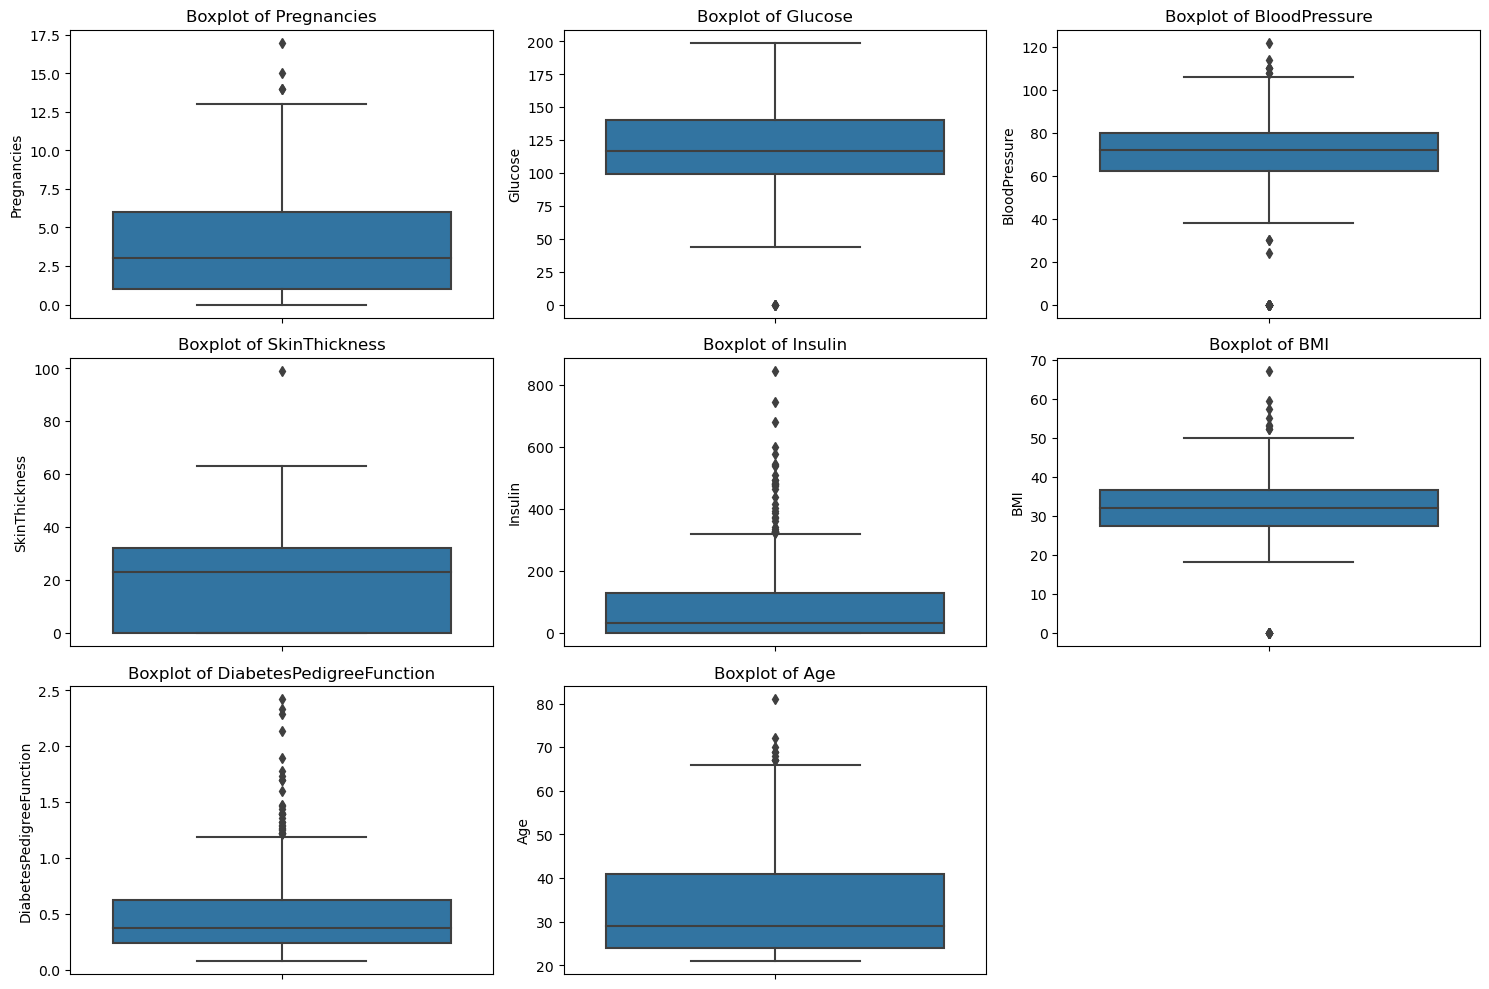

In [4]:
# Checking distribution of data and outliers via boxplot
plt.figure(figsize=(15, 10))

for i, column in enumerate(df.columns[:-1], 1): 
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

# there are some extreme values for the dataset, we will inspect. 

In [5]:
# We can see some features are skewed due to '0' entries (Glucose, Blood Pressure, Skin Thickness, Insulin, BMI)
# After consideration, I've decided to impute the 0 entries using K-Nearest Neighbours as the dataset is small,
# and KNN will impute the values to a more appropriate value rather than using median or mean. 
# I also use IQR to determine upper and lower bounds to cap any extreme values in the dataset. 

# Using KNN to imput as our dataset is considered 'small'. KNN uses the 
# values from the 0 values' nearest neighbours which is better than using the median and mean
# I use IQR to determine the upper and lower bound and extreme values will be capped at the bounds
# 0 values are then imputed with KNN.

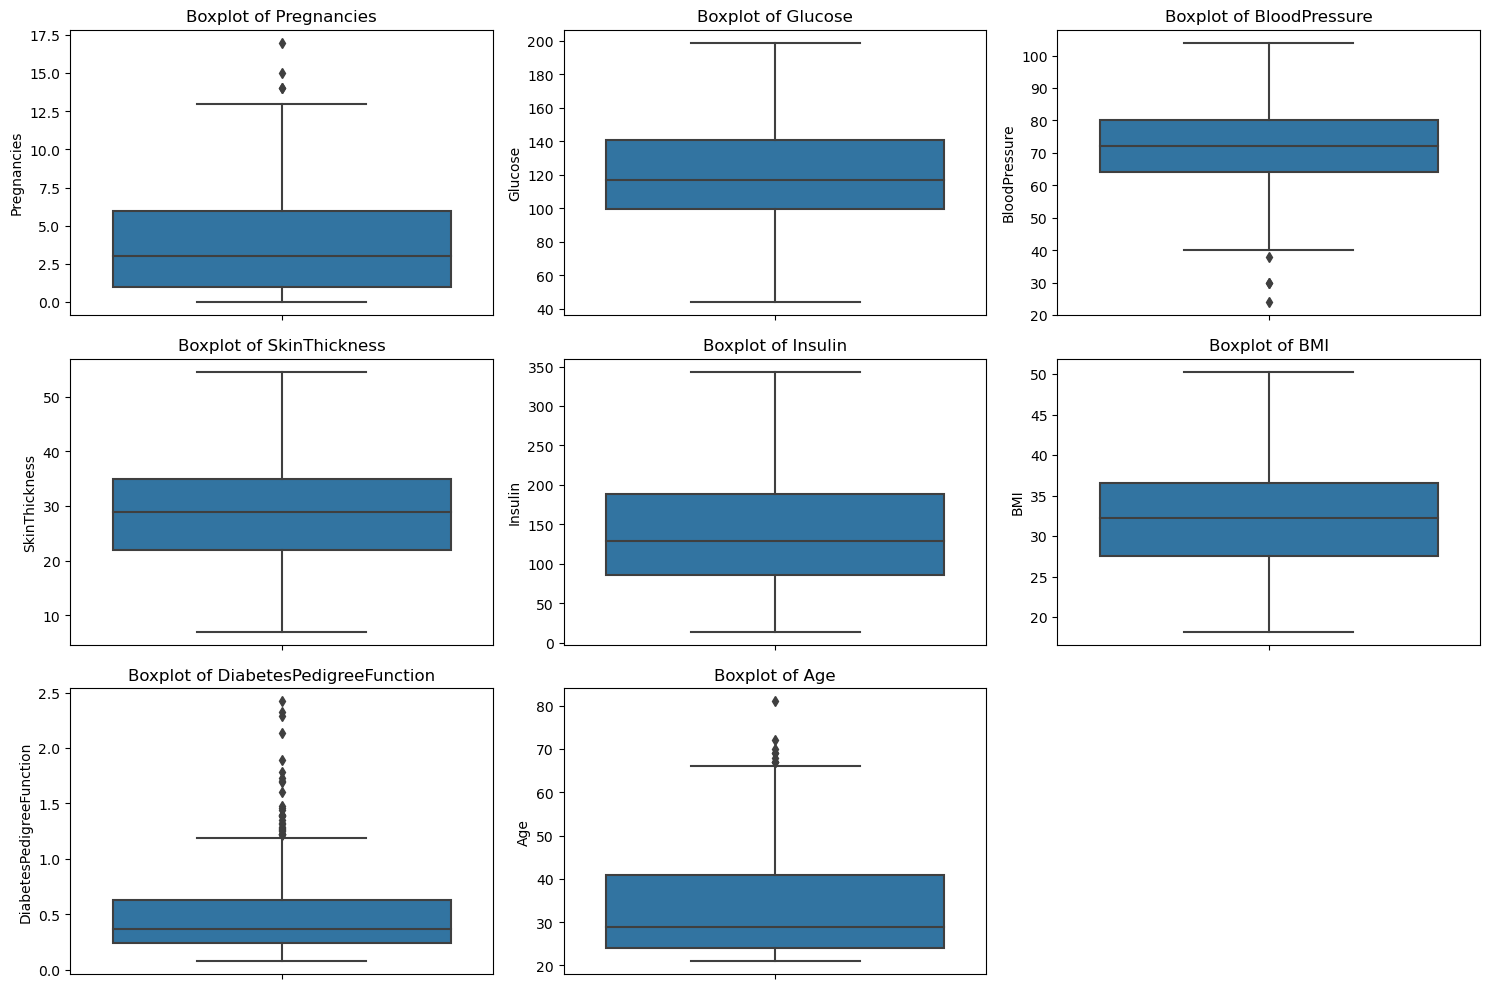

In [6]:
# Select features to impute zeros: Glucose, BloodPressure, SkinThickness, Insulin, BMI
features_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[features_to_impute] = df[features_to_impute].replace(0, np.nan)
knn_imputer = KNNImputer(n_neighbors=5)
df[features_to_impute] = knn_imputer.fit_transform(df[features_to_impute])

# Defining upper and lower bounds (IQR)
for feature in features_to_impute:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    # Cap values greater than the upper bound
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])

    # Checking distribution after cleaning
plt.figure(figsize=(15, 10))

for i, column in enumerate(df.columns[:-1], 1):  # Skip 'Outcome' as it's the label
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [7]:
# Scaling
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Features to StandardScale 
features_standard_scaled = ['Glucose', 'BloodPressure', 'BMI']

# Features to MinMaxScale
features_minmax_scaled = ['Pregnancies','SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

# StandardScale
df[features_standard_scaled] = standard_scaler.fit_transform(df[features_standard_scaled])

# MinMax
df[features_minmax_scaled] = minmax_scaler.fit_transform(df[features_minmax_scaled])


# I've applied StandardScaler to features Glucose, BloodPressure, and BMI, which are likely to benefit from 
# standard scaling due to their normal distribution. 
# For features like SkinThickness, Insulin, DiabetesPedigreeFunction, and Age, 
# I applied MinMaxScaler to scale them between 0 and 1, given their varied or bounded nature

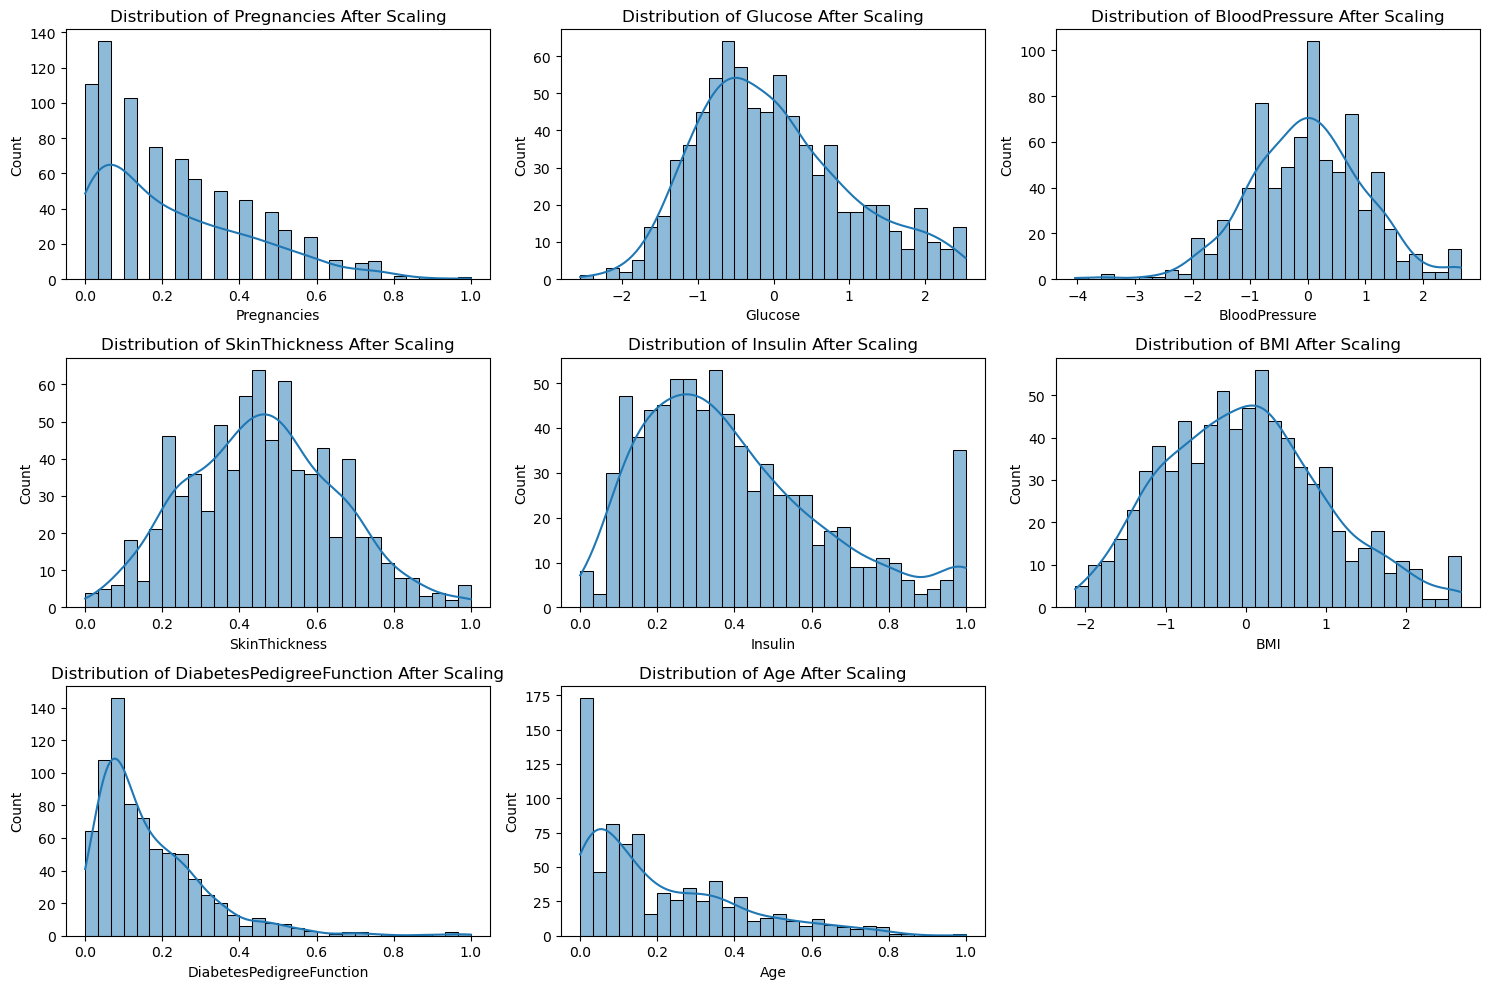

In [8]:
# Visualizing distribution after scaling
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):  # Skip 'Outcome' as it's the label
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column} After Scaling')

plt.tight_layout()
plt.show()
# The distribution of data seems much better now and appropriate to train the model on.

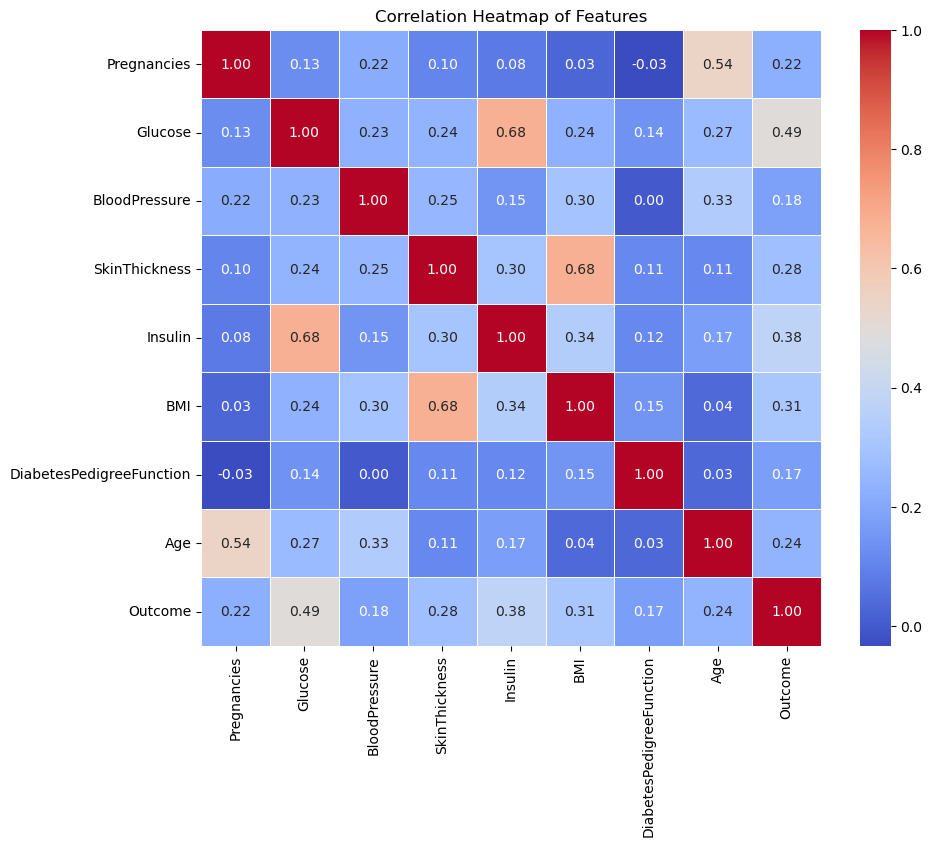

In [9]:
# Plot a correlation heatmap to analyze the relationships between features
plt.figure(figsize=(10, 8))

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()

In [10]:
# From the correlation matrix above, there doesn't seem to be any features that have
# > 0.9 correlation, so I assumed there is no redundant features.

In [11]:
# Splitting dataset
# Split features and labels
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
# Baseline Perceptron
# I use sklearn's perceptron model here as a baseline model. It will be initialised with very basic parameters
# to act as a baseline before hyperparameter tuning in later steps.

perceptron_model = Perceptron(max_iter=100, tol=1e-3, random_state=42)
perceptron_model.fit(X_train, y_train)
base_y_pred = perceptron_model.predict(X_test)
base_report = classification_report(y_test, base_y_pred)
print("Classification Report for Baseline Perceptron:")
print(base_report)

Classification Report for Baseline Perceptron:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       100
           1       0.51      0.61      0.55        54

    accuracy                           0.66       154
   macro avg       0.64      0.65      0.64       154
weighted avg       0.67      0.66      0.66       154



In [13]:
# Hypertuned Perceptron
# In this step, I iterate through different parameter settings with GridSearchCV in order to find the
# best performing settings. 

# Hyperparameter Tuning
# Define the parameter grid to search for the best hyperparameters
param_grid = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [100,500, 1000, 2000],
    'tol': [0.001, 0.0001, 0.00001],
    'eta0': [0.001, 0.01, 0.1, 1.0],
    'random_state': [42]
}

perceptron = Perceptron()
grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print out the results
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score * 100:.2f}%")


# Now that we have the best settings, we initialize a model with this setting and train it.
# Initialize the Perceptron model with the best parameters found
best_perceptron = Perceptron(
    alpha=0.01, 
    eta0=1.0, 
    max_iter=500, 
    penalty='l1', 
    random_state=42, 
    tol=0.001
)
best_perceptron.fit(X_train, y_train)
y_pred_best = best_perceptron.predict(X_test)
tuned_report = classification_report(y_test, y_pred_best)
print("Classification Report for Tuned Perceptron:")
print(tuned_report)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best Parameters: {'alpha': 0.001, 'eta0': 0.1, 'max_iter': 100, 'penalty': 'l1', 'random_state': 42, 'tol': 0.001}
Best Cross-Validation Accuracy: 76.22%
Classification Report for Tuned Perceptron:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       100
           1       0.62      0.48      0.54        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



In [14]:
# even the perceptron with the best settings are displaying poor results for class '1' which can indicate
# a class imbalance. I will try to balance class weights and rerun the model.

# Initialize the Perceptron with class weights
final_model = Perceptron(
    alpha=0.01,
    eta0=1.0,
    max_iter=500,
    penalty='l1',
    random_state=42,
    tol=0.001,
    class_weight='balanced'
)

# Train the model
final_model.fit(X_train, y_train)


# Train the model on the training data
final_model.fit(X_train, y_train)

# Make predictions on the test set
final_y_pred = final_model.predict(X_test)

# Generate and print the classification report for the model with class weights
final_report = classification_report(y_test, final_y_pred)
print("Classification Report (Hypertuned and Class Balanced):")
print(final_report)

Classification Report (Hypertuned and Class Balanced):
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       100
           1       0.57      0.87      0.69        54

    accuracy                           0.73       154
   macro avg       0.74      0.76      0.72       154
weighted avg       0.79      0.73      0.73       154



In [15]:
# Initialize the Multi-Layer Perceptron classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), 
                    activation='relu',          
                    solver='adam',              
                    max_iter=3000,              
                    random_state=42)

# Train the MLP on the upsampled training data
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred_mlp = mlp.predict(X_test)

# Generate and print the classification report for the MLP model
report_mlp = classification_report(y_test, y_pred_mlp)
print("Classification Report for MLP Classifier:")
print(report_mlp)

Classification Report for MLP Classifier:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.65      0.57      0.61        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.73      0.74      0.74       154



In [16]:
# Define the parameter grid for GridSearchCV to tune the MLP classifier
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [3000, 5000],
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True],       
    'n_iter_no_change': [10, 20]
}
mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='recall', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params_mlp = grid_search.best_params_
best_mlp = grid_search.best_estimator_
y_pred_best_mlp = best_mlp.predict(X_test)
report_best_mlp = classification_report(y_test, y_pred_best_mlp)
print(f"Best Hyperparameters for MLP: {best_params_mlp}")
print("Classification Report for Best MLP Classifier:")
print(report_best_mlp)


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best Hyperparameters for MLP: {'activation': 'tanh', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 3000, 'n_iter_no_change': 10, 'solver': 'sgd'}
Classification Report for Best MLP Classifier:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       100
           1       0.60      0.67      0.63        54

    accuracy                           0.73       154
   macro avg       0.70      0.71      0.71       154
weighted avg       0.74      0.73      0.73       154



In [17]:
from sklearn.svm import SVC

# Implementing a basic SVM from scikit-learn's library with rbf kernel.
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pred)
svc_report = classification_report(y_test, y_pred)

print(svc_report)

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       100
           1       0.65      0.48      0.55        54

    accuracy                           0.73       154
   macro avg       0.70      0.67      0.68       154
weighted avg       0.72      0.73      0.72       154

